In [2]:
import mlflow
import os
from typing import Dict
from tavily import TavilyClient
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display

In [5]:
tracking_uri = "http://127.0.0.1:5000"
mlflow.set_tracking_uri(tracking_uri)

In [6]:
experiment = mlflow.set_experiment("udacity")

2025/12/03 01:49:00 INFO mlflow.tracking.fluent: Experiment with name 'udacity' does not exist. Creating a new experiment.


In [7]:
@mlflow.trace
def add(a, b):
    return a + b

In [8]:
add(1, 2)

3

Trace(trace_id=tr-c399822e22683e9b42d4ae1316fb3651)

**Logging Traces**

In [10]:
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key=os.getenv("OPEN_AI_API_KEY")
)

In [11]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(question)
    return response

In [12]:
class State(MessagesState):
    question: str
    answer: str

In [13]:
llm_with_tools = llm.bind_tools([web_search])

In [14]:
def entry_point(state: State):
    question = state["question"]
    system_message = SystemMessage("You conduct web search to respond to user's questions")
    human_message = HumanMessage(question)
    messages = [system_message, human_message]
    return {"messages": messages}

In [15]:
def agent(state: State):
    messages = state["messages"]
    ai_message = llm_with_tools.invoke(messages)
    return {"messages": ai_message, "answer": ai_message.content}

In [16]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [17]:
workflow = StateGraph(State)
workflow.add_node("entry_point", entry_point)
workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode([web_search]))

workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "agent")
workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)
workflow.add_edge("tools", "agent")

In [18]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["tools"], 
    checkpointer=memory
)

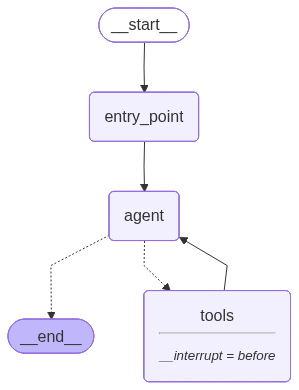

In [19]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [20]:
mlflow.langchain.autolog()

In [21]:
input_question = {"question": "what's the capital of Brazil?"}
config = {"configurable": {"thread_id": 1}}

In [22]:
for event in graph.stream(input=input_question, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

2025/12/03 01:52:26 WARNING mlflow.tracing.fluent: Found non-string values in metadata. Non-string values in metadata will automatically be stringified when the trace is logged. Non-string items: {'mlflow.trace.session': 1}


2025/12/03 01:52:26 WARNING mlflow.tracing.fluent: Found non-string values in metadata. Non-string values in metadata will automatically be stringified when the trace is logged. Non-string items: {'mlflow.trace.session': 1}
2025/12/03 01:52:26 WARNING mlflow.tracing.fluent: Found non-string values in metadata. Non-string values in metadata will automatically be stringified when the trace is logged. Non-string items: {'mlflow.trace.session': 1}


================================ Human Message =================================

what's the capital of Brazil?


2025/12/03 01:52:28 WARNING mlflow.tracing.fluent: Found non-string values in metadata. Non-string values in metadata will automatically be stringified when the trace is logged. Non-string items: {'mlflow.trace.session': 1}


================================== Ai Message ==================================
Tool Calls:
  web_search (call_JFj1nyWCLarFLvU0gw2Bchsa)
 Call ID: call_JFj1nyWCLarFLvU0gw2Bchsa
  Args:
    question: capital of Brazil


Trace(trace_id=tr-efd10b98d7d40322d4907146563035ed)

In [19]:
state = graph.get_state(config=config)

In [20]:
state.next

('tools',)

In [21]:
for event in graph.stream(input=None, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  web_search (call_r01YVNEEf0APiSnLPfaHXuEG)
 Call ID: call_r01YVNEEf0APiSnLPfaHXuEG
  Args:
    question: What is the capital of Brazil?
================================= Tool Message =================================
Name: web_search

{"query": "What is the capital of Brazil?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Brasília - Wikipedia", "url": "https://en.wikipedia.org/wiki/Brasília", "content": "445 Region Latin America and the Caribbean Brasília (/brəˈzɪliə/ brə-ZIL-ee-ə,[4][5] Portuguese: [bɾaˈzili.ɐ, bɾaˈziljɐ] ⓘ) is the capital city of Brazil. Located in the Brazilian highlands in the country's Central-West region, it is the seat of government of the Federal District. It was founded by President Juscelino Kubitschek on 21 April 1960, to replace Rio de Janeiro as the national capital. [6] Brasília is a planned city developed by Lúcio Costa, Osc

Trace(request_id=81a1a4873e3c4efda09ae8cf97e5f9fd)